# Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Определение констант

In [2]:
palette = sns.color_palette("tab10") # Цвета для графиков
data_path = 'data/'
goods = ['Бензак', 'Броня и одежда', 'Жидкости для тачки', 'Медпрепараты и еда',
         'Модификации тачки', 'Оружие', 'Патроны', 'Солярка', 'Съедобный хлам',
         'Хлам', 'Ядер-Кола']
random_state = 1543

# Загрузка данных

In [3]:
shops = pd.read_parquet(data_path + 'shops.parquet')
sales_pivoted = pd.read_csv('sales_pivoted.csv')
sales_pivoted['date'] = pd.to_datetime(sales_pivoted['date'])

# Доли продаж товаров

In [4]:
# Просуммируем продажы для каждого магазина и дня
sum_over_index = sales_pivoted.drop(['date', 'shop_id'], axis = 'columns').sum(axis = 'columns')

In [5]:
# Посчитаем долю продаж каждого товара в каждый день
shares = sales_pivoted.copy()
for good in goods:
    shares[good] = shares[good]/sum_over_index

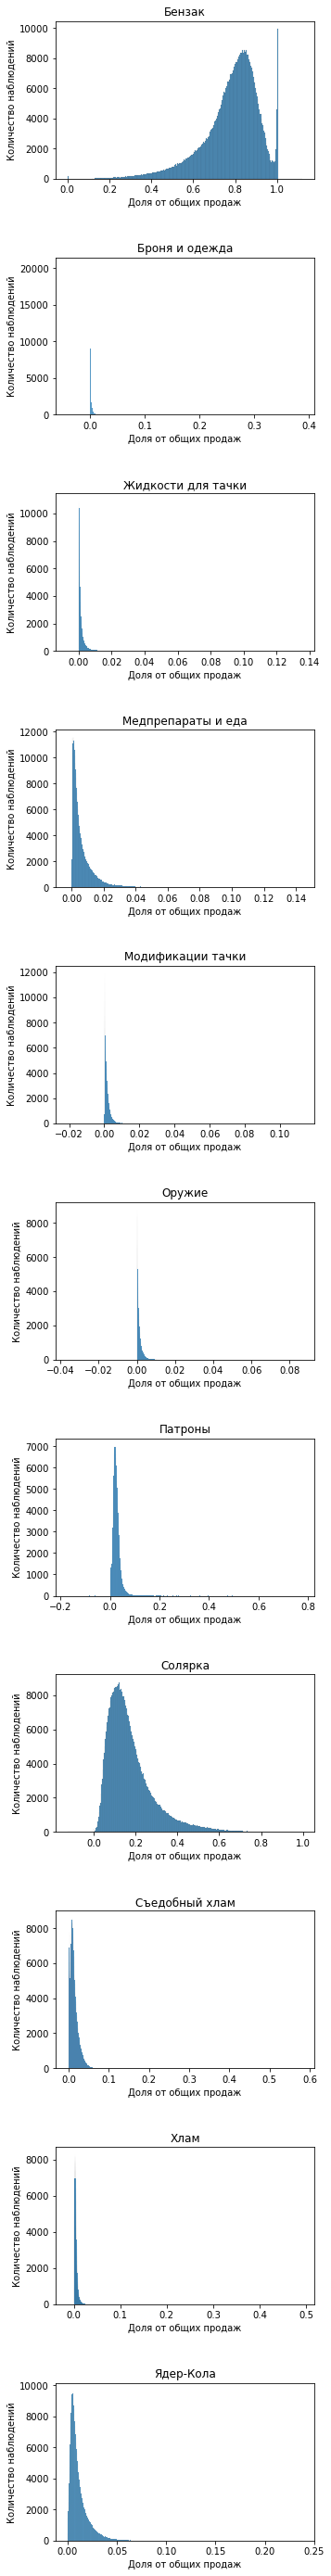

In [6]:
fig, axs = plt.subplots(11, 1, figsize = (5, 50))
plt.subplots_adjust(hspace = 0.5)

for good, cur_ax in zip(goods, axs):
    sns.histplot(shares[good].values, ax = cur_ax, palette = palette)
    cur_ax.set_title(good)
    cur_ax.set_ylabel('Количество наблюдений')
    cur_ax.set_xlabel('Доля от общих продаж')

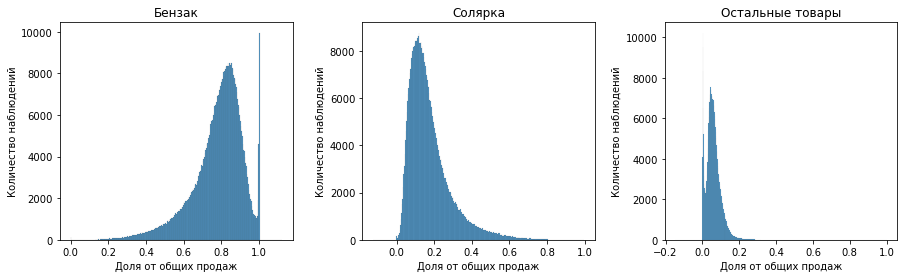

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
plt.subplots_adjust(wspace = 0.3)

for good, cur_ax in zip(['Бензак', 'Солярка', 'Остальные товары'], axs):
    
    # Распределение долей продаж бензака и солярки
    if good!= 'Остальные товары':
        sns.histplot(shares[good].values, ax = cur_ax, palette = palette)
        cur_ax.set_title(good)
        cur_ax.set_ylabel('Количество наблюдений')
        cur_ax.set_xlabel('Доля от общих продаж')
    
    # Распрделение суммарныхы долей продаж нетопливных товаров
    else:
        shares_other = shares.drop(['date', 'shop_id', 'Бензак', 'Солярка', 'number_of_counters'], axis = 'columns').sum(axis = 'columns')
        shares_other = shares_other[shares_other!=0]
        sns.histplot(shares_other, ax = cur_ax)
        cur_ax.set_title('Остальные товары')
        cur_ax.set_ylabel('Количество наблюдений')
        cur_ax.set_xlabel('Доля от общих продаж')

Видно, что бензак и солярка составляют основную долю продаж в большинстве магазинов в большую часть дней.\
Следовательно, остальные товары являются "сопутствующими"

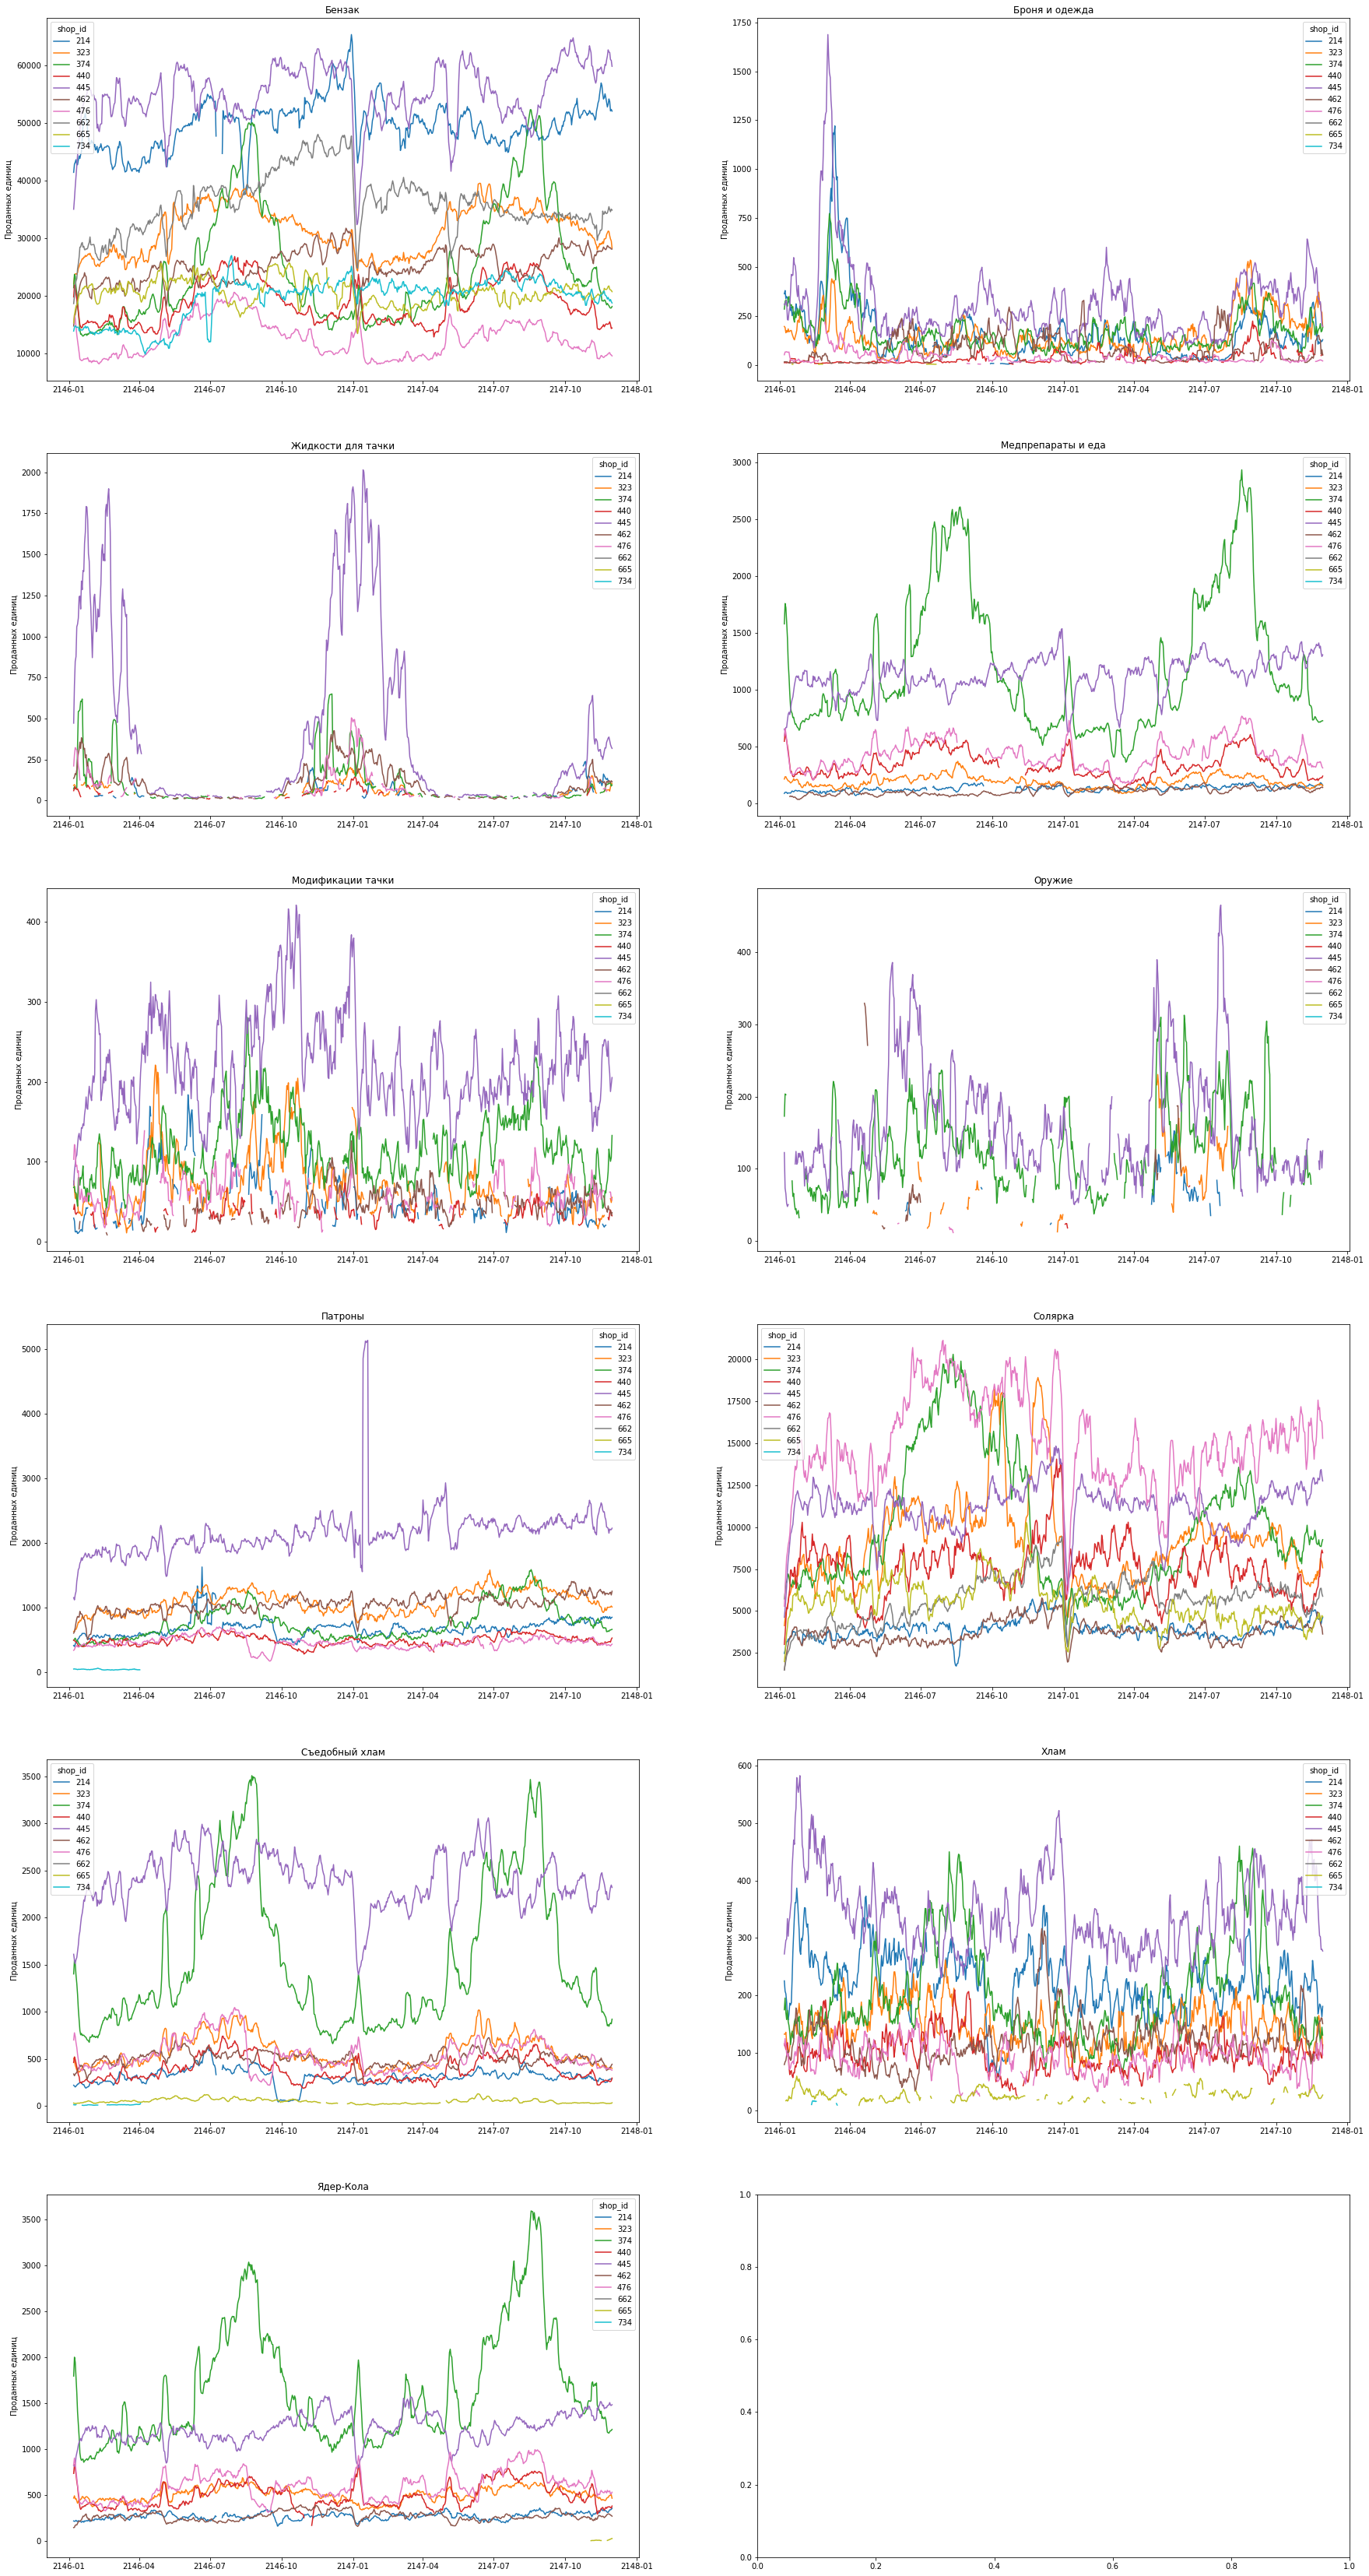

In [8]:
np.random.seed(random_state)
sampled_shops = np.random.choice(shops['shop_id'].values, 10, replace = False)


fig, ax = plt.subplots(6, 2, figsize = (30, 60))
row = 0
col = 0
for good in goods:
    data = sales_pivoted[sales_pivoted['shop_id'].isin(sampled_shops)].reset_index(drop = True)
    # Посчитаем скользящее среднее продаж товара по магазинам
    # Это поможет снизить зашумленность данных=> визуализация станет более понятной
    data[good] = data.groupby('shop_id')[good].rolling(7).mean().reset_index(drop = True)
    _ = sns.lineplot(x = 'date', 
                     y = good,
                     hue = 'shop_id',
                     data = data,
                     palette = palette, 
                     ax = ax[row][col])
    ax[row][col].set_xlabel('')
    ax[row][col].set_ylabel('Проданных единиц')
    ax[row][col].set_title(good)
    if col == 1:
        row = row+1
        col = 0
    else:
        col = col+1

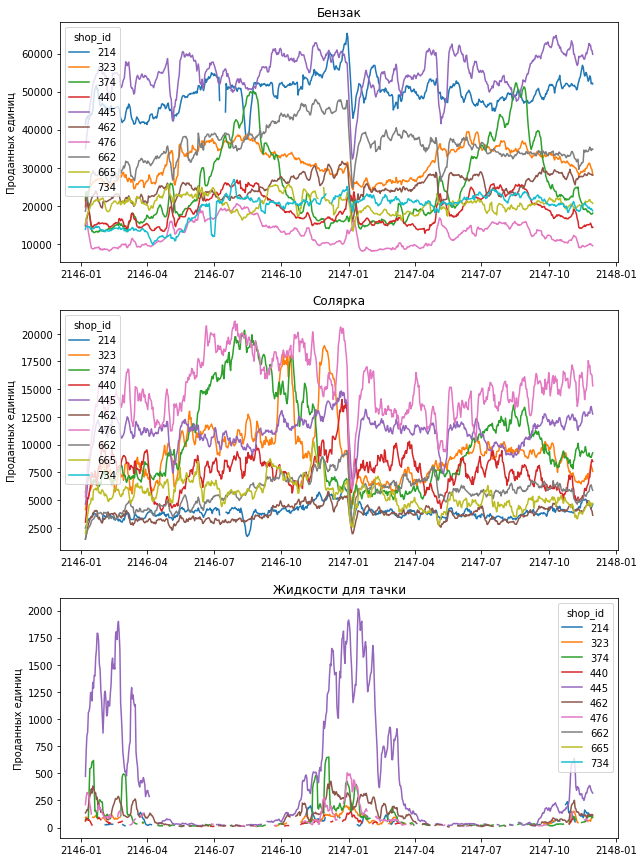

In [9]:
fig, axs = plt.subplots(3, 1, figsize = (10, 15))
for good, cur_ax in zip(['Бензак', 'Солярка', 'Жидкости для тачки'], axs):
    data = sales_pivoted[sales_pivoted['shop_id'].isin(sampled_shops)].reset_index(drop = True)
    data[good] = data.groupby('shop_id')[good].rolling(7).mean().reset_index(drop = True)
    _ = sns.lineplot(x = 'date', 
                     y = good,
                     hue = 'shop_id',
                     data = data,
                     palette = palette, 
                     ax = cur_ax)
    cur_ax.set_xlabel('')
    cur_ax.set_ylabel('Проданных единиц')
    cur_ax.set_title(good)

In [10]:
# Посчитаем среднее количество пропущеннных данных о товарах в каждый день для каждого магазина
mean_missed = sales_pivoted.groupby('shop_id')\
                           .apply(lambda x: x.isnull().sum(axis = 'columns')\
                           .mean())\
                           .sort_values(ascending = False)

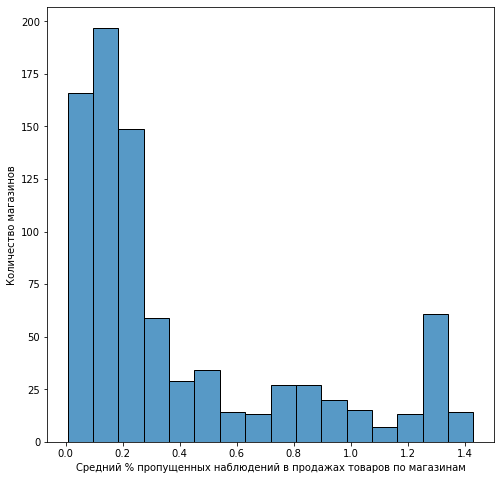

In [11]:
plt.figure(figsize = (8, 8))
sns.histplot((mean_missed/699)*100, palette = palette)
plt.ylabel('Количество магазинов')
_ = plt.xlabel('Средний % пропущенных наблюдений в продажах товаров по магазинам')